# SINGAPORE PUBLIC HOUSING RESALE MARKET ANALYSIS

## 1. Data Cleaning and Mining

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

from dython.nominal import correlation_ratio

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, median_absolute_error
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTENC

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV

In [2]:
df_raw = pd.read_csv('resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv')

#change the 'month' column name to 'year_month'
df_raw = df_raw.rename(columns={'month':'year_month'})

# change data type in year_month column to date time
df_raw['year_month'] = pd.to_datetime(df_raw['year_month'], format='%Y-%m')

# extract year and month into separate columns from year_month
df_raw['month'] = df_raw['year_month'].dt.month
df_raw['year'] = df_raw['year_month'].dt.year

# rearrange the column's order
col = list(np.array(df_raw.columns)[[0, 11, 12]]) + list(np.array(df_raw.columns)[1:11])
df = df_raw[col]

df.head()

,year_month,month,year,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01-01,1,2017,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01-01,1,2017,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01-01,1,2017,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01-01,1,2017,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01-01,1,2017,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


In [3]:
#check the null and column's type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118166 entries, 0 to 118165
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   year_month           118166 non-null  datetime64[ns]
 1   month                118166 non-null  int64         
 2   year                 118166 non-null  int64         
 3   town                 118166 non-null  object        
 4   flat_type            118166 non-null  object        
 5   block                118166 non-null  object        
 6   street_name          118166 non-null  object        
 7   storey_range         118166 non-null  object        
 8   floor_area_sqm       118166 non-null  float64       
 9   flat_model           118166 non-null  object        
 10  lease_commence_date  118166 non-null  int64         
 11  remaining_lease      118166 non-null  object        
 12  resale_price         118166 non-null  float64       
dtypes: datetime64[

In [4]:
# extract each year and month from remaining lease and convert it into year (numeric)
year_rl = df['remaining_lease'].str.split(" ", expand=True)[0].fillna(0).astype(int)
month_rl = df['remaining_lease'].str.split(" ", expand=True)[2].fillna(0).astype(int)
df['year_remaining_lease'] = year_rl + (month_rl/12).round(decimals=2)

# extract median from storey_range
min_sr = df['storey_range'].str.split(" ", expand=True)[0].astype(int)
max_sr = df['storey_range'].str.split(" ", expand=True)[2].astype(int)
df['med_storey_range'] = (min_sr + max_sr)/2

# drop the unuse columns 
df = df.drop(columns=['remaining_lease'])

df.head()

,year_month,month,year,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,year_remaining_lease,med_storey_range
0,2017-01-01,1,2017,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,232000.0,61.33,11.0
1,2017-01-01,1,2017,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,250000.0,60.58,2.0
2,2017-01-01,1,2017,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,262000.0,62.42,2.0
3,2017-01-01,1,2017,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,265000.0,62.08,5.0
4,2017-01-01,1,2017,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,265000.0,62.42,2.0


### - Per Town prespective

In [5]:
# extract number of street name and block per town
town_1 = pd.DataFrame(df.groupby("town")[[ 
                "block", 
                "street_name"]].nunique()).reset_index().rename(columns={
                                    "block" : "n_block_per_town",    
                                    "street_name" : "n_street_name_per_town"
                                })
town_1.head()

,town,n_block_per_town,n_street_name_per_town
0,ANG MO KIO,348,15
1,BEDOK,402,25
2,BISHAN,227,10
3,BUKIT BATOK,347,21
4,BUKIT MERAH,209,43


### - Per block prespective

In [6]:
# extract number of street name and block per town
block_1 = pd.DataFrame(df.groupby("block")[[ 
                "street_name"]].nunique()).reset_index().rename(columns={  
                                    "street_name" : "n_street_name_per_block"
                                })
block_1.head()

,block,n_street_name_per_block
0,1,23
1,10,18
2,100,4
3,101,27
4,101A,2


### - Merge Table

In [7]:
df_merge = pd.merge(df, town_1, on="town", how="outer")
df_merge = pd.merge(df_merge, block_1, on="block", how="outer")
df_merge.head()

,year_month,month,year,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,year_remaining_lease,med_storey_range,n_block_per_town,n_street_name_per_town,n_street_name_per_block
0,2017-01-01,1,2017,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,232000.0,61.33,11.0,348,15,14
1,2017-05-01,5,2017,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,235000.0,61.08,11.0,348,15,14
2,2018-03-01,3,2018,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,01 TO 03,44.0,Improved,1979,202000.0,60.17,2.0,348,15,14
3,2018-03-01,3,2018,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,01 TO 03,44.0,Improved,1979,210000.0,60.17,2.0,348,15,14
4,2018-05-01,5,2018,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,07 TO 09,44.0,Improved,1979,220000.0,60.08,8.0,348,15,14


__Correlation__

finding the correlation between the resale price and other numeric fields

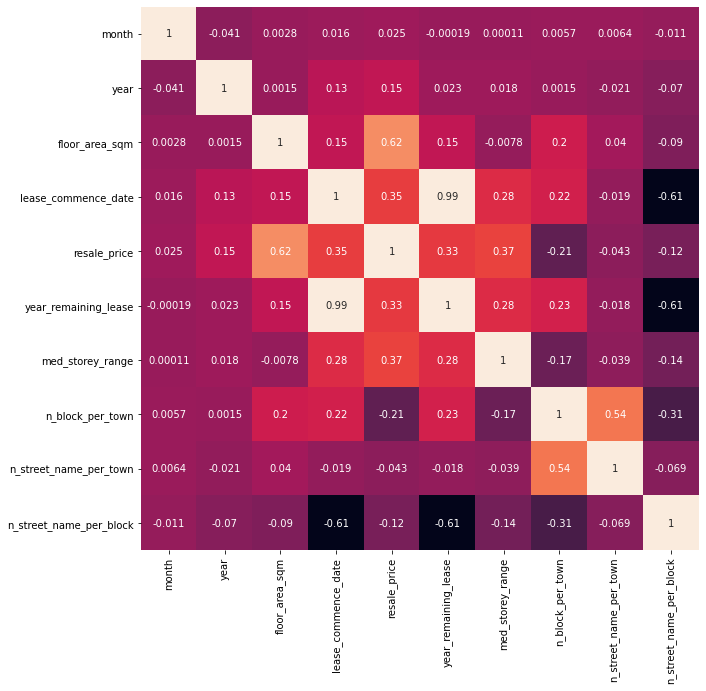

In [8]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_merge.corr(), annot=True, cbar=False)
plt.show()

__Correlation ratio__

finding the correlation between the resale price and other categoric fields

In [9]:
cat = [i for i in df_merge.columns if i not in df_merge.corr().columns and i != "year_month"]

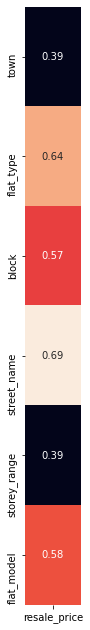

In [10]:
corr_rat = []
for i in cat:
    a = round(correlation_ratio(df_merge[i], df_merge["resale_price"]), 2)
    corr_rat.append(a)

data_corr_rat = pd.DataFrame(data = [corr_rat], columns = cat, index=["resale_price"])
plt.figure(figsize=(1, 11))
sns.heatmap(data_corr_rat.T, annot=True, cbar=False)
plt.show()

### Building a Model

__DROP UNUSE FIELDS__

In [31]:
# drop resale_price, year_month and storey_range and block columns
# dropping block column because too much unique values

df_model = df_merge.drop(columns=["storey_range", "year_month", "block"])

# drop the row for street_name == 'SEMBAWANG WAY' because only one row

df_model = df_model[df_model["street_name"]!='SEMBAWANG WAY']
df_model.head()

,month,year,town,flat_type,street_name,floor_area_sqm,flat_model,lease_commence_date,resale_price,year_remaining_lease,med_storey_range,n_block_per_town,n_street_name_per_town,n_street_name_per_block
0,1,2017,ANG MO KIO,2 ROOM,ANG MO KIO AVE 10,44.0,Improved,1979,232000.0,61.33,11.0,348,15,14
1,5,2017,ANG MO KIO,2 ROOM,ANG MO KIO AVE 10,44.0,Improved,1979,235000.0,61.08,11.0,348,15,14
2,3,2018,ANG MO KIO,2 ROOM,ANG MO KIO AVE 10,44.0,Improved,1979,202000.0,60.17,2.0,348,15,14
3,3,2018,ANG MO KIO,2 ROOM,ANG MO KIO AVE 10,44.0,Improved,1979,210000.0,60.17,2.0,348,15,14
4,5,2018,ANG MO KIO,2 ROOM,ANG MO KIO AVE 10,44.0,Improved,1979,220000.0,60.08,8.0,348,15,14


In [32]:
df_model[df_model["street_name"]=='SEMBAWANG WAY']

,month,year,town,flat_type,street_name,floor_area_sqm,flat_model,lease_commence_date,resale_price,year_remaining_lease,med_storey_range,n_block_per_town,n_street_name_per_town,n_street_name_per_block


__SPLITTING DATA__

In [33]:
# seperate the columns into X and Y

X = df_model.drop(columns='resale_price')
y = df_model['resale_price']

In [34]:
# data splitting

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)

__PIPELINE__

we used pipeline method for modelling
in a pipeline there are :
1. Robust scaler for Numeric Columns
2. One hot encoding for categoric columns

In [35]:
num_columns = [i for i in X_train.corr().columns]
cat_columns = [i for i in X_train.columns if i not in num_columns]

In [36]:
# create pipeline and model

numeric_pipeline = Pipeline([
    ('scaler', RobustScaler()),
#     ('poly', PolynomialFeatures(degree=2, include_bias=False)),
#     ('power', PowerTransformer(method='yeo-johnson'))
])

categoric_pipeline = Pipeline([
    ('encoder', OneHotEncoder())
])

preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, num_columns),
    ('categorical', categoric_pipeline, cat_columns)
])

pipe_LR = Pipeline([
    ('prep', preprocessor),
    ('algo', LinearRegression())
])

pipe_SVM = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=600))
])

pipe_DT = Pipeline([
    ('prep', preprocessor),
    ('algo', DecisionTreeRegressor(random_state=42))
])

__DEF FUNCTION FOR EVALUATION MATRIX__

Create a function that return the evaluation matrix (precission, recall, accuracy and confusion metrix

In [37]:
# def function for each model evaluation matrix

def component(Model, X, y_true):
    y_pred = Model.predict(X)
    R2 = r2_score(y_true, y_pred)
    MAE = mean_absolute_error(y_true, y_pred)
    MSE = mean_squared_error(y_true, y_pred)
    RMSE = np.sqrt(MSE)
    return R2, MAE, MSE, RMSE
def eva_matrix (Model, X_train, X_test, y_train, y_test,Nama):
    r2_tr, MAE_tr, MSE_tr, RMSE_tr = component(Model, X_train, y_train)
    r2_ts, MAE_ts, MSE_ts, RMSE_ts = component(Model, X_test, y_test)
    data = {
    Nama + "Training" : [r2_tr, MAE_tr, MSE_tr, RMSE_tr],
    Nama + "Testing" : [r2_ts, MAE_ts, MSE_ts, RMSE_ts]
        }
    return pd.DataFrame(data = data, index = ['R2', 'MAE', 'MSE', 'RMSE'])

__MODEL FITTING__

###########################

_LINEAR REGRESSION_

###########################

In [38]:
pipe_LR.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['month', 'year',
                                                   'floor_area_sqm',
                                                   'lease_commence_date',
                                                   'year_remaining_lease',
                                                   'med_storey_range',
                                                   'n_block_per_town',
                                                   'n_street_name_per_town',
                                                   'n_street_name_per_block']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                       

In [46]:
# evaluation matrix of Logistic regression base model

EVA_LR = eva_matrix(pipe_LR, X_train, X_test, y_train, y_test, 'Linear Regression Base ')
EVA_LR

,Linear Regression Base Training,Linear Regression Base Testing
R2,9.229366e-01,9.226749e-01
MAE,3.374272e+04,3.419960e+04
MSE,1.948392e+09,1.993866e+09
RMSE,4.414059e+04,4.465273e+04


###########################

_Support Vector Machine (SVM)_

###########################

In [41]:
pipe_SVM.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['month', 'year',
                                                   'floor_area_sqm',
                                                   'lease_commence_date',
                                                   'year_remaining_lease',
                                                   'med_storey_range',
                                                   'n_block_per_town',
                                                   'n_street_name_per_town',
                                                   'n_street_name_per_block']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                       

In [47]:
# evaluation matrix of SVM base model

EVA_SVM = eva_matrix(pipe_SVM, X_train, X_test, y_train, y_test, 'SVM Base ')
EVA_SVM

,SVM Base Training,SVM Base Testing
R2,-6.218831e-01,-6.107571e-01
MAE,1.768438e+05,1.783208e+05
MSE,4.100604e+10,4.153418e+10
RMSE,2.024995e+05,2.037994e+05


###########################

_DECISION TREE_

###########################

In [43]:
pipe_DT.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['month', 'year',
                                                   'floor_area_sqm',
                                                   'lease_commence_date',
                                                   'year_remaining_lease',
                                                   'med_storey_range',
                                                   'n_block_per_town',
                                                   'n_street_name_per_town',
                                                   'n_street_name_per_block']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                       

In [48]:
# evaluation matrix of Decision Tree base model

EVA_DT = eva_matrix(pipe_DT, X_train, X_test, y_train, y_test, 'DT Base ')
EVA_DT

,DT Base Training,DT Base Testing
R2,9.997542e-01,9.481461e-01
MAE,3.835600e+02,2.578692e+04
MSE,6.214411e+06,1.337079e+09
RMSE,2.492872e+03,3.656610e+04


### Comparing Base Models's Evaluation Matrix

In [67]:
comparison_EVA = pd.concat([EVA_LR, EVA_SVM, EVA_DT], axis=1)[[i for i in pd.concat([EVA_LR, EVA_SVM, EVA_DT], axis=1).columns if "Testing" in i]]
comparison_EVA

,Linear Regression Base Testing,SVM Base Testing,DT Base Testing
R2,9.226749e-01,-6.107571e-01,9.481461e-01
MAE,3.419960e+04,1.783208e+05,2.578692e+04
MSE,1.993866e+09,4.153418e+10,1.337079e+09
RMSE,4.465273e+04,2.037994e+05,3.656610e+04


##  1

### The same case like in Classification (Blk 12 TOH YI DR. It’s a 5-room flat so the size is approximately 120 sqm) , but the price is 700,000 SGD. is the price reasonable ?

In [85]:
df_merge[(df_merge["block"]=="12") & (df_merge["street_name"]=="TOH YI DR") & (df_merge["flat_type"]=="5 ROOM")][df_merge.columns[:12]]

,year_month,month,year,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
72919,2019-01-01,1,2019,BUKIT TIMAH,5 ROOM,12,TOH YI DR,04 TO 06,122.0,Improved,1989,750000.0
72921,2019-05-01,5,2019,BUKIT TIMAH,5 ROOM,12,TOH YI DR,07 TO 09,122.0,Improved,1989,768000.0
72922,2021-06-01,6,2021,BUKIT TIMAH,5 ROOM,12,TOH YI DR,07 TO 09,122.0,Improved,1989,889000.0


Based on the historical data, the minumum price of flats in 12 TOH YI DR with 5 ROOM type is 750,000 SGD. That price was 3 years ago. The newest data (2021) is around 889,000 SGD. In conclusion, it is __unreasonable__ if the price is 700,000 SGD. you should check the flat if its necessary.

## 2 The reasonable Price ?

The reasonable price for the criteria in Number 1 at the second half of 2021 is __889,000 SGD__ 

- month = 01
- year = 2022
- town = df_model[df_model["street_name"].str.contains("TOH YI")]["town"].unique()[0]
- flat_type = 5 ROOM
- street name = "TOH YI DR
- floor area = 120 
- flat_model = df_merge[(df_merge["block"]=="12") & (df_merge["street_name"]=="TOH YI DR") & (df_merge["floor_area_sqm"]>=120)]["flat_model"].unique()[0]
- lease_commence_date = df_merge[(df_merge["block"]=="12") & (df_merge["street_name"]=="TOH YI DR") & (df_merge["floor_area_sqm"]>=120)]["lease_commence_date"].unique()[0]
- remaining lease = 60
- med_storey_range = 10
- n_block per town = town_1[town_1["town"] == df_model[df_model["street_name"].str.contains("TOH YI")]["town"].unique()[0]]["n_block_per_town"].iloc[0]
- n_street name per town = town_1[town_1["town"] == df_model[df_model["street_name"].str.contains("TOH YI")]["town"].unique()[0]]["n_street_name_per_town"].iloc[0]
- n_street name per block = block_1[block_1["block"]=="12"]["n_street_name_per_block"].iloc[0]

In [108]:
input_town_1 = df_model[df_model["street_name"].str.contains("TOH YI")]["town"].unique()[0]
input_data_1 = [12, 2021, input_town_1, "5 ROOM"
                , "TOH YI DR", 120
                , df_merge[(df_merge["block"]=="12") & (df_merge["street_name"]=="TOH YI DR") & (df_merge["floor_area_sqm"]>=120)]["flat_model"].unique()[0]
                , df_merge[(df_merge["block"]=="12") & (df_merge["street_name"]=="TOH YI DR") & (df_merge["floor_area_sqm"]>=120)]["lease_commence_date"].unique()[0]
                , 60, 10,  town_1[town_1["town"]==input_town_1]["n_block_per_town"].iloc[0]
                , town_1[town_1["town"]==input_town_1]["n_street_name_per_town"].iloc[0]
                , block_1[block_1["block"]=="12"]["n_street_name_per_block"].iloc[0]]

In [109]:
# make def function for translating the model result

def translate (list_input):
    y_pred = pipe_DT.predict(pd.DataFrame(data=[list_input], columns=list(X_test.columns)))[0]
    return y_pred

In [110]:
MAE_model_DT = comparison_EVA[[i for i in comparison_EVA.columns if "DT" in i][0]].loc["MAE"]
print("The reasonable price should within the range " 
      + '\033[1m'
      + str(round(translate (input_data_1)-MAE_model_DT, 2)) 
      + '\033[0m'
      + " SGD and " 
      + '\033[1m'
      + str(round(translate (input_data_1)+MAE_model_DT, 2))
      + '\033[0m'
      + " SGD")

The reasonable price should within the range 914213.08 SGD and 965786.92 SGD
